# AI-Powered Sentiment Analysis
## Using Pre-trained Transformer Models (BERT)

**Purpose**: Analyze sentiment of news articles and social posts using state-of-the-art NLP

In [1]:
# Setup
import sys
sys.path.append('../..')

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from pipeline.models.database import Database

print("Libraries loaded")

Libraries loaded


In [2]:
# Load AI Sentiment Model
print("🤖 Loading transformer model...")
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    device=-1 
)
print("AI model loaded successfully!")

🤖 Loading transformer model...



Device set to use cpu


AI model loaded successfully!


In [3]:
# Load ALL Data from Database
db = Database()
db.connect()

# check total records
with db.get_cursor(dict_cursor=True) as cursor:
    cursor.execute("SELECT COUNT(*) as total FROM raw_data")
    total = cursor.fetchone()['total']
    print(f"Total records in database: {total:,}")

# Load ALL records
print("Loading all records...")
with db.get_cursor(dict_cursor=True) as cursor:
    cursor.execute("""
        SELECT id, source, title, snippet, source_type, fetched_at
        FROM raw_data
        ORDER BY fetched_at DESC
    """)
    data = cursor.fetchall()

df = pd.DataFrame(data)
print(f"Loaded {len(df):,} records for AI analysis")
print(f"\nSources: {df['source'].value_counts().to_dict()}")
print(f"Types: {df['source_type'].value_counts().to_dict()}")
df.head()

✅ Connected to PostgreSQL
Total records in database: 8,026
Loading all records...
Loaded 8,026 records for AI analysis

Sources: {'X (Twitter) [Simulated]': 7740, 'Ada Derana': 179, 'The Island': 107}
Types: {'social': 7740, 'news': 286}


,id,source,title,snippet,source_type,fetched_at
0,11460,The Island,Starmer to host Zelensky for Ukraine talks in ...,"Henry, Santner, Nathan Smith ruled out of rest...",news,2025-12-08 18:18:59.006895
1,11459,The Island,Jetstar to launch Australia’s only low-cost di...,"Henry, Santner, Nathan Smith ruled out of rest...",news,2025-12-08 18:18:58.245658
2,11458,The Island,President chairs Nuwara Eliya District Special...,"Henry, Santner, Nathan Smith ruled out of rest...",news,2025-12-08 18:18:56.956866
3,11457,The Island,Level III landslide early warnings issued to t...,"Henry, Santner, Nathan Smith ruled out of rest...",news,2025-12-08 18:18:56.458068
4,11456,The Island,"Henry, Santner, Nathan Smith ruled out of rest...","Henry, Santner, Nathan Smith ruled out of rest...",news,2025-12-08 18:18:55.456678


In [4]:
# Prepare Text for Analysis
df['text'] = df['title'] + ' ' + df['snippet'].fillna('')
df['text'] = df['text'].str[:512]  # Truncate to model limit

print("Text prepared for AI analysis")

Text prepared for AI analysis


In [5]:
# Run AI Sentiment Analysis
print(f"🤖 Running AI sentiment analysis on {len(df):,} records...")
print("⏱️  Estimated time: ~{} minutes".format(int(len(df) / 200)))

results = []
batch_size = 32 
failed = 0

for i in range(0, len(df), batch_size):
    batch = df['text'].iloc[i:i+batch_size].tolist()
    
    try:
        batch_results = sentiment_analyzer(batch)
        results.extend(batch_results)
    except Exception as e:
        # If batch fails, process individually
        print(f"Batch {i//batch_size} failed, processing individually...")
        for text in batch:
            try:
                results.append(sentiment_analyzer(text)[0])
            except:
                results.append({'label': 'NEUTRAL', 'score': 0.5})
                failed += 1
    
    # Progress indicator
    if (i // batch_size) % 25 == 0:
        progress = (i / len(df)) * 100
        print(f"  Progress: {progress:.1f}% ({i:,}/{len(df):,} records)")

print(f"AI analysis complete!")
print(f"   Processed: {len(results):,} records")
print(f"   Failed: {failed} records")

🤖 Running AI sentiment analysis on 8,026 records...
⏱️  Estimated time: ~40 minutes
  Progress: 0.0% (0/8,026 records)
  Progress: 10.0% (800/8,026 records)
  Progress: 19.9% (1,600/8,026 records)
  Progress: 29.9% (2,400/8,026 records)
  Progress: 39.9% (3,200/8,026 records)
  Progress: 49.8% (4,000/8,026 records)
  Progress: 59.8% (4,800/8,026 records)
  Progress: 69.8% (5,600/8,026 records)
  Progress: 79.7% (6,400/8,026 records)
  Progress: 89.7% (7,200/8,026 records)
  Progress: 99.7% (8,000/8,026 records)
AI analysis complete!
   Processed: 8,026 records
   Failed: 0 records


In [6]:
# Add AI Results to DataFrame
df['ai_sentiment'] = [r['label'] for r in results]
df['ai_confidence'] = [r['score'] for r in results]
df['ai_sentiment_score'] = df.apply(
    lambda x: x['ai_confidence'] if x['ai_sentiment'] == 'POSITIVE' else -x['ai_confidence'],
    axis=1
)

print("AI sentiment scores added")
df[['source', 'title', 'ai_sentiment', 'ai_confidence']].head(10)

AI sentiment scores added


,source,title,ai_sentiment,ai_confidence
0,The Island,Starmer to host Zelensky for Ukraine talks in ...,POSITIVE,0.995682
1,The Island,Jetstar to launch Australia’s only low-cost di...,NEGATIVE,0.595614
2,The Island,President chairs Nuwara Eliya District Special...,POSITIVE,0.985657
3,The Island,Level III landslide early warnings issued to t...,NEGATIVE,0.880312
4,The Island,"Henry, Santner, Nathan Smith ruled out of rest...",POSITIVE,0.995617
5,The Island,Thousands flee Thai-Cambodia border after dead...,POSITIVE,0.985272
6,The Island,Government assures University community of sup...,POSITIVE,0.995319
7,The Island,"Powerful earthquake strikes off Japan, trigger...",POSITIVE,0.993207
8,The Island,Indonesia counts human cost as more climate ch...,NEGATIVE,0.625341
9,The Island,New mpox strain identified in England,POSITIVE,0.991301


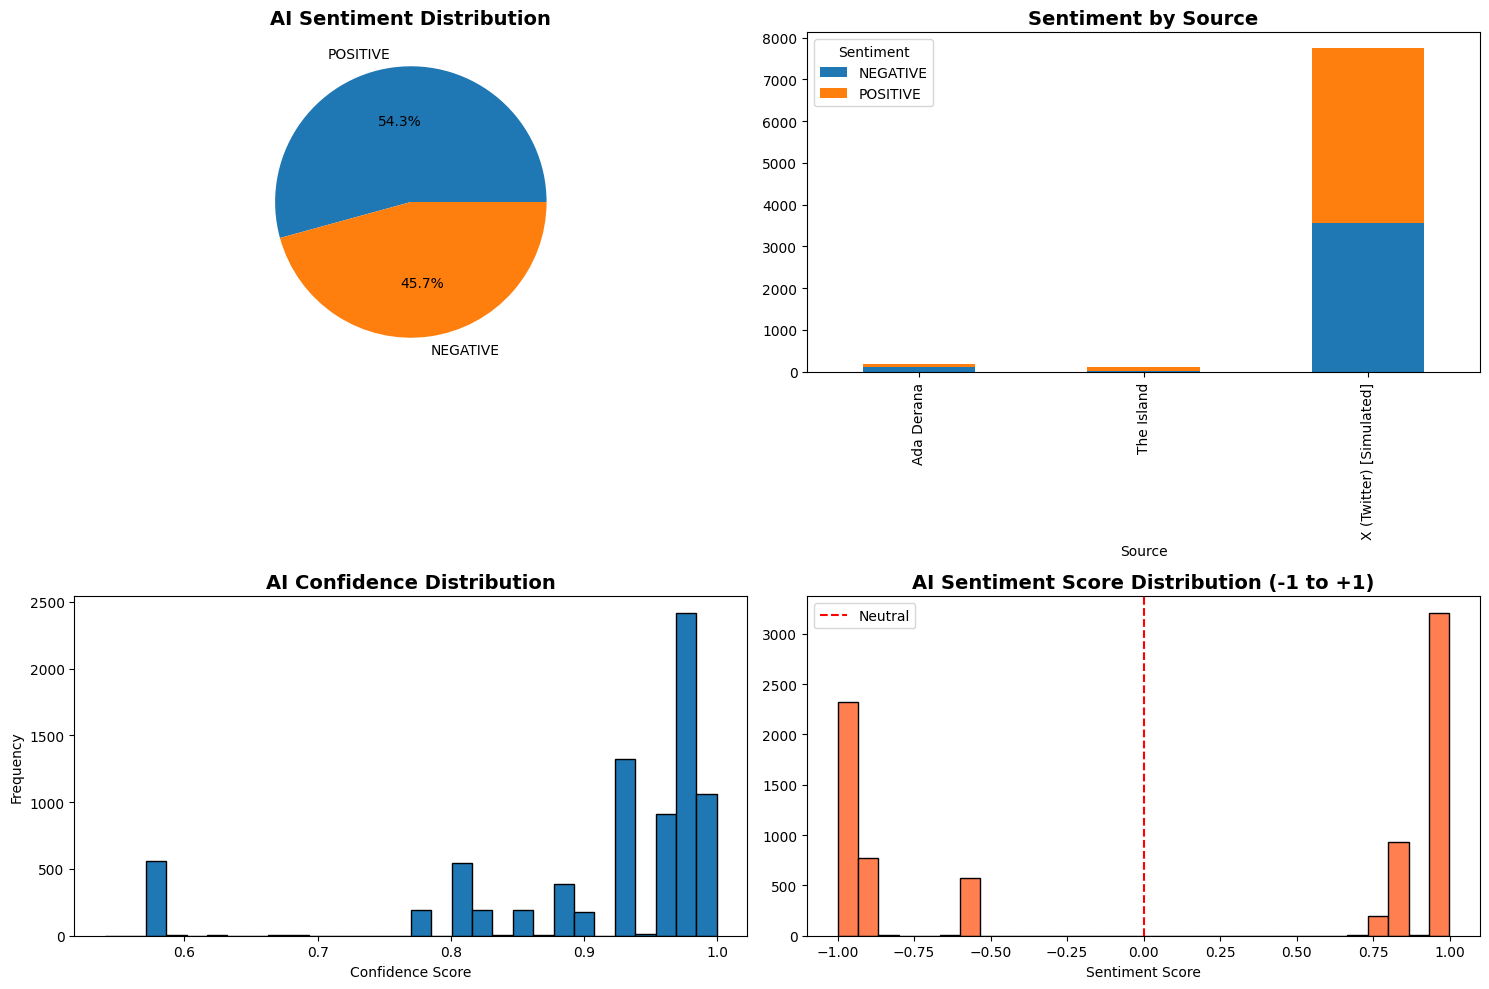

Visualization saved!


In [7]:
# Visualize AI Sentiment Distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Overall Sentiment Distribution
sentiment_counts = df['ai_sentiment'].value_counts()
axes[0, 0].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')
axes[0, 0].set_title('AI Sentiment Distribution', fontsize=14, fontweight='bold')

# 2. Sentiment by Source
sentiment_by_source = pd.crosstab(df['source'], df['ai_sentiment'])
sentiment_by_source.plot(kind='bar', stacked=True, ax=axes[0, 1])
axes[0, 1].set_title('Sentiment by Source', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Source')
axes[0, 1].legend(title='Sentiment')

# 3. Confidence Score Distribution
axes[1, 0].hist(df['ai_confidence'], bins=30, edgecolor='black')
axes[1, 0].set_title('AI Confidence Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Confidence Score')
axes[1, 0].set_ylabel('Frequency')

# 4. Sentiment Score Distribution
axes[1, 1].hist(df['ai_sentiment_score'], bins=30, edgecolor='black', color='coral')
axes[1, 1].axvline(x=0, color='red', linestyle='--', label='Neutral')
axes[1, 1].set_title('AI Sentiment Score Distribution (-1 to +1)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Sentiment Score')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('ai_sentiment_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved!")

In [8]:
# AI Insights Summary
print("="*70)
print("🤖 AI SENTIMENT ANALYSIS SUMMARY")
print("="*70)

avg_sentiment = df['ai_sentiment_score'].mean()
print(f"\n📊 Overall Sentiment Score: {avg_sentiment:.3f}")

if avg_sentiment < -0.3:
    mood = "Very Negative"
elif avg_sentiment < -0.1:
    mood = "Negative"
elif avg_sentiment < 0.1:
    mood = "Neutral"
elif avg_sentiment < 0.3:
    mood = "Positive"
else:
    mood = "Very Positive"

print(f"Public Mood: {mood}\n")

print("Distribution:")
for sentiment, count in df['ai_sentiment'].value_counts().items():
    pct = (count / len(df)) * 100
    print(f"  {sentiment}: {count} ({pct:.1f}%)")

print(f"\nAverage AI Confidence: {df['ai_confidence'].mean():.3f}")
print("="*70)

🤖 AI SENTIMENT ANALYSIS SUMMARY

📊 Overall Sentiment Score: 0.102
Public Mood: Positive

Distribution:
  POSITIVE: 4356 (54.3%)
  NEGATIVE: 3670 (45.7%)

Average AI Confidence: 0.913


In [9]:
# Save AI Results to Database
print("💾 Saving AI sentiment scores to database...")

with db.get_cursor() as cursor:
    for _, row in df.iterrows():
        cursor.execute("""
            UPDATE raw_data
            SET metadata = COALESCE(metadata, '{}'::jsonb) ||
                          jsonb_build_object(
                              'ai_sentiment', %s,
                              'ai_confidence', %s,
                              'ai_sentiment_score', %s
                          )
            WHERE id = %s
        """, (
            row['ai_sentiment'],
            float(row['ai_confidence']),
            float(row['ai_sentiment_score']),
            row['id']
        ))

print("AI sentiment scores saved to database!")
db.disconnect()

💾 Saving AI sentiment scores to database...
AI sentiment scores saved to database!
👋 Disconnected from PostgreSQL


In [10]:
# Export for Dashboard
df[['source', 'title', 'ai_sentiment', 'ai_confidence', 'ai_sentiment_score']].to_csv(
    'ai_sentiment_results.csv',
    index=False
)
print("Results exported to CSV for dashboard!")

Results exported to CSV for dashboard!
